In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
from numpy import mean, sqrt, std
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return np.abs((mean(x) - mean(y))/sqrt(((nx-1)*std(x,ddof=1)**2+(ny-1)*std(y, ddof=1)**2)/dof))

In [3]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur=conn.cursor()

In [ ]:
from PIL import Image
northwind_sql =Image.open('Northwind_ERD_updated.png')
northwind_sql

# how to insert an image in the markdown cell:
# ![](name of image)

In [ ]:
# No need to run this cell because the OrderDetail table has already been altered to have this column
# cur.execute("""ALTER TABLE OrderDetail             
#                 ADD Revenue money;""")

In [4]:
# Only run this cell to get the values into the new Revenue column
cur.execute("""UPDATE OrderDetail
               SET Revenue = (UnitPrice*Quantity)-(UnitPrice*Quantity*Discount)""")

In [5]:
# New OrderDetail table
cur.execute("""SELECT *
               FROM OrderDetail""")
orderdetail = pd.DataFrame(cur.fetchall())
orderdetail.columns = [x[0] for x in cur.description]
display(orderdetail.head())
len(orderdetail)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


2155

___

## Looking through Product Table

In [78]:
# this give us the products that are being sold with their price 
# important things to note from here is that there are some products that are discontinued
# reorder level?
cur.execute("""SELECT *
               FROM Product""")
product = pd.DataFrame(cur.fetchall())
product.columns = [x[0] for x in cur.description]
display(product.head(11))
len(product)
# discontinued 1 is yes 0 is no?

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
5,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.00,120,0,25,0
6,7,Uncle Bob's Organic Dried Pears,3,7,12 - 1 lb pkgs.,30.00,15,0,10,0
7,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00,6,0,0,0
8,9,Mishi Kobe Niku,4,6,18 - 500 g pkgs.,97.00,29,0,0,1
9,10,Ikura,4,8,12 - 200 ml jars,31.00,31,0,0,0


77

In [ ]:
cur.execute("""SELECT *
               FROM Product p
               JOIN Category c
               ON p.CategoryId = c.Id
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               JOIN [Order] o
               ON od.OrderId = o.Id
               WHERE Discontinued IS 1""")
product_discontinued = pd.DataFrame(cur.fetchall())
product_discontinued.columns = [x[0] for x in cur.description]
display(product_discontinued.head())
len(product_discontinued)

In [ ]:
cur.execute("""SELECT *
               FROM Product
               WHERE Discontinued IS 0""")
product_continued = pd.DataFrame(cur.fetchall())
product_continued.columns = [x[0] for x in cur.description]
display(product_continued.head())
len(product_continued)

In [8]:
# looking at this list, it shows that each line in the above dataframe is actually a different product
# that means that they are selling 77 distinct products
# What type of products are these?
cur.execute("""SELECT DISTINCT(ProductName)
               FROM Product""")
product_name = pd.DataFrame(cur.fetchall())
product_namecolumns = [x[0] for x in cur.description]
display(product_name.head())
len(product_name)

,0
0,Chai
1,Chang
2,Aniseed Syrup
3,Chef Anton's Cajun Seasoning
4,Chef Anton's Gumbo Mix


77

___

## Looking through Supplier Table

In [9]:
# there are 29 companys that northwind is working with that gives them their supplies.
cur.execute("""SELECT *
               FROM Supplier""")
supplier = pd.DataFrame(cur.fetchall())
supplier.columns = [x[0] for x in cur.description]
display(supplier.head(2))
len(supplier)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#


29

In [10]:
# Northwind suppliers come from 16 different countries
# Ordering by country lets us see that some countries have different companies that are being used
# Maybe we can compare the revenue being made in the different companies in a specific country?
# Maybe we can compare the regions?
cur.execute("""SELECT Region, Country, CompanyName
               FROM Supplier
               ORDER BY Country""")
supplier_country = pd.DataFrame(cur.fetchall())
supplier_country.columns = [x[0] for x in cur.description]
display(supplier_country.head(2))
len(supplier_country)

,Region,Country,CompanyName
0,Victoria,Australia,"Pavlova, Ltd."
1,NSW,Australia,"G'day, Mate"


29

In [11]:
cur.execute("""SELECT *
               FROM OrderDetail""")
orderdetail = pd.DataFrame(cur.fetchall())
orderdetail.columns = [x[0] for x in cur.description]
display(orderdetail.head(2))
len(orderdetail)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0


2155

In [12]:
# I want to see if I could see where the orders are coming from... orderdetail quantity, with product, 
# connected to supplier
cur.execute("""SELECT CompanyName, Region, od.UnitPrice, Quantity, Discount, Revenue
               FROM Supplier s
               JOIN Product p
               ON s.Id = p.SupplierId
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               ORDER BY Region""")
supplier_product_od = pd.DataFrame(cur.fetchall())
supplier_product_od.columns = [x[0] for x in cur.description]
display(supplier_product_od.head(2))
len(supplier_product_od)

,CompanyName,Region,UnitPrice,Quantity,Discount,Revenue
0,"Specialty Biscuits, Ltd.",British Isles,64.8,40,0.05,2462.4
1,Exotic Liquids,British Isles,15.2,20,0.00,304.0


2155

In [13]:
cur.execute("""SELECT CompanyName, Region, Revenue
               FROM Supplier s
               JOIN Product p
               ON s.Id = p.SupplierId
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               
               """)
supplier_product_od = pd.DataFrame(cur.fetchall())
supplier_product_od.columns = [x[0] for x in cur.description]
display(supplier_product_od.head(2))
len(supplier_product_od)

,CompanyName,Region,Revenue
0,Cooperativa de Quesos 'Las Cabras',Southern Europe,168.0
1,Leka Trading,South-East Asia,98.0


2155

**Question:**
With a confidence level of 95%, does a supplier from a certain region lead to higher revenue on average? If so, which region?

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
sm.stats.anova_lm(ols('Revenue ~ Region', data=supplier_product_od).fit())
# p-value is less than alpha(0.05) which shows that we can reject the null - there is at least one difference

,df,sum_sq,mean_sq,F,PR(>F)
Region,10.0,1.539531e+08,1.539531e+07,17.655769,2.802947e-31
Residual,2144.0,1.869505e+09,8.719706e+05,NaN,NaN


In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(supplier_product_od['Revenue'], supplier_product_od['Region'])
tukey_results.summary()
# use tukey hsd to find where that difference is

group1,group2,meandiff,lower,upper,reject
British Isles,Eastern Asia,23.8529,-318.537,366.2427,False
British Isles,NSW,313.1516,-52.2706,678.5739,False
British Isles,North America,135.9445,-114.6761,386.565,False
British Isles,Northern Europe,-46.6002,-363.3404,270.14,False
British Isles,Scandinavia,52.5435,-252.2277,357.3148,False
British Isles,South America,-268.1884,-735.8094,199.4326,False
British Isles,South-East Asia,155.901,-233.4049,545.207,False
British Isles,Southern Europe,183.3999,-100.6534,467.4533,False
British Isles,Victoria,296.6182,-14.3386,607.575,False
British Isles,Western Europe,706.1398,458.3385,953.9412,True


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


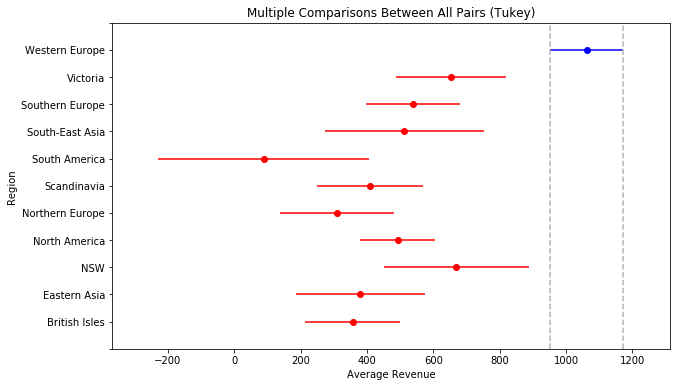

In [16]:
tukey_results.plot_simultaneous(comparison_name='Western Europe', ylabel='Region', xlabel='Average Revenue').show()
# note - the dots are the means and the lines are the confidence intervals
# looking at the results, Western Europe supplies more products over the other regions with a higher 
# mean total cost than 
# the other regions
# All the other regions are too similar (no statistical difference) to say that there is any effect on the total_cost?

In [17]:
# look at suppliers that sell the same category types, check to see if the average revenue is different?
cur.execute("""SELECT CategoryName, Region, Revenue
               FROM Supplier s
               JOIN Product p
               ON s.Id = p.SupplierId
               JOIN Category c
               ON p.CategoryId = c.Id
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               
               """)
supplier_category = pd.DataFrame(cur.fetchall())
supplier_category.columns = [x[0] for x in cur.description]
display(supplier_category.head(2))
len(supplier_category)

,CategoryName,Region,Revenue
0,Dairy Products,Southern Europe,168.0
1,Grains/Cereals,South-East Asia,98.0


2155

**Question:**
Is there a greater revenue for the different types of categories being supplied, with a 95% confidence level?

In [18]:
# H0: All categorys are equal
# Ha: At least one is different
import statsmodels.api as sm
from statsmodels.formula.api import ols
sm.stats.anova_lm(ols('Revenue ~ CategoryName', data=supplier_category).fit())
# p-value is less than 0.05 which means we can reject the null use tukey hsd to find where the difference is

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,4.639896e+07,6.628422e+06,7.198177,1.536802e-08
Residual,2147.0,1.977059e+09,9.208473e+05,NaN,NaN


In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_category = pairwise_tukeyhsd(supplier_category['Revenue'], supplier_category['CategoryName'])
tukey_category.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-172.0813,-417.4777,73.315,False
Beverages,Confections,-161.9705,-377.2755,53.3345,False
Beverages,Dairy Products,-22.3098,-232.3991,187.7796,False
Beverages,Grains/Cereals,-174.5473,-427.9707,78.8762,False
Beverages,Meat/Poultry,279.2857,14.7624,543.8091,True
Beverages,Produce,72.1407,-216.4794,360.7608,False
Beverages,Seafood,-265.2772,-481.2954,-49.2591,True
Condiments,Confections,10.1108,-244.0866,264.3082,False
Condiments,Dairy Products,149.7716,-100.0235,399.5667,False
Condiments,Grains/Cereals,-2.4659,-289.6653,284.7335,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


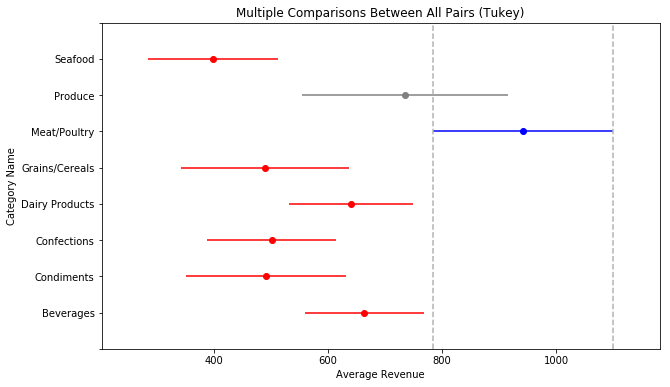

In [20]:
tukey_category.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='Category Name', xlabel='Average Revenue').show()
# The results show that even though there might be a difference, all the categories interact with one another
# it's ok to say that seafood makes the least amount of money on average, but it is not statiscally different
# then Grains/Cereals, Confections, and Condiments.  Same goes for Meat/Poultry, it seems to make the most
# money on average, but it is not statiscally different than produce.

**Question:**
Is the average revenue from a supplier in a certain region different depending on the category that it is supplying?

In [21]:
# H0: All region are the same
# Ha: At least one is different
sm.stats.anova_lm(ols('Revenue ~ Region*CategoryName', data=supplier_category).fit())
# p-value is less than alpha so we can reject the null

,df,sum_sq,mean_sq,F,PR(>F)
Region,10.0,1.539531e+08,1.539531e+07,19.846453,1.909393e-35
CategoryName,7.0,3.381987e+07,4.831411e+06,6.228283,3.044388e-07
Region:CategoryName,70.0,2.050450e+08,2.929215e+06,3.776118,1.563310e-22
Residual,2114.0,1.639874e+09,7.757211e+05,NaN,NaN


In [22]:
tukey_sup_cat = pairwise_tukeyhsd(supplier_category['Revenue'], supplier_category['Region']+supplier_category['CategoryName'])
tukey_sup_cat.summary()

group1,group2,meandiff,lower,upper,reject
British IslesBeverages,British IslesCondiments,-101.7487,-1164.7849,961.2875,False
British IslesBeverages,British IslesConfections,11.6003,-476.4011,499.6018,False
British IslesBeverages,Eastern AsiaCondiments,-57.9445,-1512.5341,1396.645,False
British IslesBeverages,Eastern AsiaMeat/Poultry,1089.8846,-494.4589,2674.2282,False
British IslesBeverages,Eastern AsiaProduce,-57.5871,-752.0254,636.8512,False
British IslesBeverages,Eastern AsiaSeafood,-1.6102,-555.0611,551.8408,False
British IslesBeverages,NSWGrains/Cereals,-243.9343,-987.0172,499.1485,False
British IslesBeverages,NSWMeat/Poultry,330.3903,-403.4864,1064.2671,False
British IslesBeverages,NSWProduce,716.8834,47.8695,1385.8972,True
British IslesBeverages,North AmericaBeverages,-10.9354,-582.1203,560.2496,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


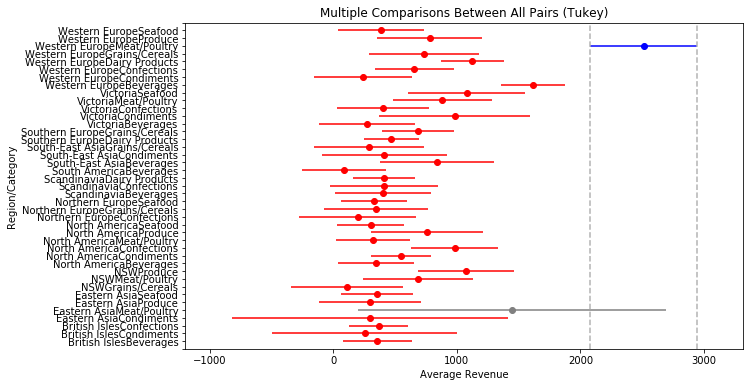

In [23]:
tukey_sup_cat.plot_simultaneous(comparison_name='Western EuropeMeat/Poultry', ylabel='Region/Category', xlabel='Average Revenue').show()

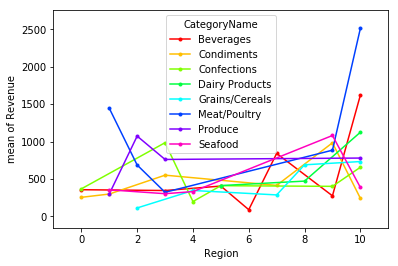

In [24]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
interaction_plot(response=supplier_category['Revenue'], trace=supplier_category['CategoryName'], x=supplier_category['Region'].astype('category').cat.codes)
plt.xlabel('Region')
plt.show()
# NOTE: Make ticks for each one and it reads from bottom to top on the x-axis
# 0 - british isles 1 - Eastern Asia and so on...
# This plot shows that Western Europe supplies the meat/poultry that generates the most revenue compared to all the 
# other regions.

___

## Looking through Region Table

In [ ]:
# We saw this in the previous table
cur.execute("""SELECT *
               FROM Region
               """)
region = pd.DataFrame(cur.fetchall())
region.columns = [x[0] for x in cur.description]
display(region.head(2))
len(region)

___

## Looking through the Order Table

In [25]:
# Note that "order" is a SQL command, so we need to put it in [] in order for it to be read
# This includes the employeeid, maybe we can look at the employees that have made the most orders?
# Maybe we can do something with the ship date - like what dates haves the most orders?
# The places that get the most orders to - region
cur.execute("""SELECT *
               FROM [Order]""")
order = pd.DataFrame(cur.fetchall())
order.columns = [x[0] for x in cur.description]
display(order.head(2))
len(order)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Revenue
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,None
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,None


830

In [26]:
cur.execute("""SELECT *
               FROM [Order]
               WHERE OrderDate LIKE '%2012%'
               ORDER BY OrderDate ASC""")
order_2012 = pd.DataFrame(cur.fetchall())
order_2012.columns = [x[0] for x in cur.description]
display(order_2012.head(2))
len(order_2012)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Revenue
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,None
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,None


152

In [27]:
cur.execute("""SELECT *
               FROM [Order]
               WHERE OrderDate LIKE '%2013%'
               ORDER BY OrderDate ASC""")
order_2013 = pd.DataFrame(cur.fetchall())
order_2013.columns = [x[0] for x in cur.description]
display(order_2013.head(2))
len(order_2013)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Revenue
0,10400,EASTC,1,2013-01-01,2013-01-29,2013-01-16,3,83.93,Eastern Connection,35 King George,London,British Isles,WX3 6FW,UK,None
1,10401,RATTC,1,2013-01-01,2013-01-29,2013-01-10,1,12.51,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA,None


408

In [28]:
cur.execute("""SELECT *
               FROM [Order]
               WHERE OrderDate LIKE '%2014%'
               ORDER BY OrderDate ASC""")
order_2014 = pd.DataFrame(cur.fetchall())
order_2014.columns = [x[0] for x in cur.description]
display(order_2014.head(2))
len(order_2014)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Revenue
0,10808,OLDWO,2,2014-01-01,2014-01-29,2014-01-09,3,45.53,Old World Delicatessen,2743 Bering St.,Anchorage,North America,99508,USA,None
1,10809,WELLI,7,2014-01-01,2014-01-29,2014-01-07,1,4.87,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil,None


270

In [29]:
cur.execute("""SELECT OrderDate, UnitPrice, Quantity, Discount
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE OrderDate LIKE '%2013%'
               ORDER BY OrderDate ASC""")
order_od_2013 = pd.DataFrame(cur.fetchall())
order_od_2013.columns = [x[0] for x in cur.description]
display(order_od_2013.head(2))
len(order_od_2013)

,OrderDate,UnitPrice,Quantity,Discount
0,2013-01-01,99.0,21,0.0
1,2013-01-01,14.4,35,0.0


1059

In [30]:
cur.execute("""SELECT *
               FROM OrderDetail""")
orderdetail = pd.DataFrame(cur.fetchall())
orderdetail.columns = [x[0] for x in cur.description]
display(orderdetail.head())
len(orderdetail)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


2155

In [31]:
cur.execute("""SELECT OrderDate, UnitPrice, Quantity, Discount, SUM(od.Revenue)
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE OrderDate LIKE '%2013%'
               ORDER BY OrderDate ASC""")
order_od_2013 = pd.DataFrame(cur.fetchall())
order_od_2013.columns = [x[0] for x in cur.description]
display(order_od_2013.head(2))
len(order_od_2013)

,OrderDate,UnitPrice,Quantity,Discount,SUM(od.Revenue)
0,2013-12-31,18.4,1,0.0,617085.2035


1

In [32]:
# This is the dataframe for all of the year of 2013 where I grouped by date
# Need to find the average and the std?
cur.execute("""SELECT OrderDate, SUM(od.Revenue) as Total_REV
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE OrderDate LIKE '%2013%'
               GROUP BY OrderDate
               ORDER BY OrderDate ASC
               """)
order_od_2013_grouped = pd.DataFrame(cur.fetchall())
order_od_2013_grouped.columns = [x[0] for x in cur.description]
display(order_od_2013_grouped.head(2))
len(order_od_2013_grouped)

,OrderDate,Total_REV
0,2013-01-01,6931.6
1,2013-01-02,2713.5


261

In [17]:
order_od_2013_grouped.head(2)

,OrderDate,Total_REV
0,2013-01-01,6931.6
1,2013-01-02,2713.5


In [19]:
print('Total rev year 2013:', order_od_2013_grouped['Total_REV'].sum())
print('average rev per day in 2013:', order_od_2013_grouped['Total_REV'].mean())
print('standard deviation of average rev in 2013:', order_od_2013_grouped['Total_REV'].std())

Total rev year 2013: 617085.2035000001
average rev per day in 2013: 2364.311124521073
standard deviation of average rev in 2013: 2267.8795286569293


In [22]:
# This is the money they are making in all the years that they have been working
cur.execute("""SELECT OrderDate, SUM(od.Revenue) as Total_REV
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE OrderDate BETWEEN 2012 AND 2014
               GROUP BY OrderDate
               ORDER BY OrderDate ASC
               """)
order_od = pd.DataFrame(cur.fetchall())
order_od.columns = [x[0] for x in cur.description]
display(order_od.head(2))
len(order_od)

,OrderDate,Total_REV
0,2012-07-04,440.0
1,2012-07-05,1863.4


390

In [23]:
print('Total of all orders 2012-2013:', order_od['Total_REV'].sum())
print('average daily for all orders 2012-2013:', order_od['Total_REV'].mean())
print('standard deviation for all orders 2012-2013:', order_od['Total_REV'].std())

Total of all orders 2012-2013: 825169.1735
average daily for all orders 2012-2013: 2115.8183935897437
standard deviation for all orders 2012-2013: 2096.224347537777


In [32]:
cur.execute("""SELECT OrderDate, SUM(od.Revenue) as Total_REV
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE OrderDate LIKE '%2014%'
               GROUP BY OrderDate
               ORDER BY OrderDate ASC""")
order_od_2014 = pd.DataFrame(cur.fetchall())
order_od_2014.columns = [x[0] for x in cur.description]
display(order_od_2014)
len(order_od_2014)

,OrderDate,Total_REV
0,2014-01-01,1738.0000
1,2014-01-02,2544.8000
2,2014-01-05,2430.8500
3,2014-01-06,19399.2950
4,2014-01-07,2450.0000
5,2014-01-08,915.9000
6,2014-01-09,4107.5600
7,2014-01-12,1573.0000
8,2014-01-13,4670.0000
9,2014-01-14,3159.5100


90

In [27]:
print('Total Rev orders 2014:', order_od_2014['Total_REV'].sum())
print('average daily for all orders 2014:', order_od_2014['Total_REV'].mean())
print('standard deviation for all orders 2014:', order_od_2014['Total_REV'].std())

Total Rev orders 2014: 440623.866
average daily for all orders 2014: 4895.820733333333
standard deviation for all orders 2014: 4405.565333644838


In [10]:
# to find effect size
from numpy import mean, sqrt, std
def cohens_d_one_sample(x, mu0):
    return (x.mean()-mu0)/x.std()

def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return np.abs((mean(x) - mean(y))/sqrt(((nx-1)*std(x,ddof=1)**2+(ny-1)*std(y, ddof=1)**2)/dof))

- Reference for power explanation: https://www.statisticsteacher.org/2017/09/15/what-is-power/
- Reference for effect size explanation: https://www.simplypsychology.org/effect-size.html

___

## Looking through the OrderDetail Table

In [75]:
# Can we figure out how much money they make?
cur.execute("""SELECT *
               FROM OrderDetail""")
orderdetail = pd.DataFrame(cur.fetchall())
orderdetail.columns = [x[0] for x in cur.description]
display(orderdetail.head(2))
len(orderdetail)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0


2155

In [9]:
cur.execute("""SELECT UnitPrice, Quantity
               FROM OrderDetail""")
unitprice_quantity = pd.DataFrame(cur.fetchall())
unitprice_quantity.columns = [x[0] for x in cur.description]
display(unitprice_quantity.head(2))
len(unitprice_quantity)

,UnitPrice,Quantity
0,14.0,12
1,9.8,10


2155

___

## Looking through the Category Table

In [6]:
# This is where we can see what type of things are being sold.. we can joing product and category tables
cur.execute("""SELECT *
               FROM Category""")
category = pd.DataFrame(cur.fetchall())
category.columns = [x[0] for x in cur.description]
display(category)
len(category)

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


8

In [7]:
# joing of the category and product table to see what we can pull out
cur.execute("""SELECT *
               FROM Product p
               JOIN Category c
               ON p.CategoryId = c.Id
               ORDER BY CategoryID""")
category_product = pd.DataFrame(cur.fetchall())
category_product.columns = [x[0] for x in cur.description]
display(category_product.head(2))
len(category_product)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,CategoryName,Description
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


77

In [8]:
display(category_product[category_product['CategoryName']=='Beverages'].head(2))
print(len(category_product[category_product['CategoryName']=='Beverages']))

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,CategoryName,Description
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


12


___

## Looking through the Employee Table

In [ ]:
# There's only 9 employees at Northwind.
# 4 employee are in the UK Region and 5 employees are in the USA region
cur.execute("""SELECT *
               FROM Employee
               """)
employee = pd.DataFrame(cur.fetchall())
employee.columns = [x[0] for x in cur.description]
display(employee.head(2))
len(employee)

**Question:**
Do employees from the USA or UK generate more revenue for Northwind?  Do individual employees in the USA or UK generate more revenue for Northwind?  If so, which employees are best?  Do their title effect their sales in any way?

In [11]:
# separating USA and UK
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, od.Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE Country = 'USA'
               """)
employee_usa = pd.DataFrame(cur.fetchall())
employee_usa.columns = [x[0] for x in cur.description]
display(employee_usa.head(2))
len(employee_usa)

,Title,Id,FirstName,City,Region,Country,Revenue
0,Sales Representative,4,Margaret,Redmond,North America,USA,77.0
1,Sales Representative,4,Margaret,Redmond,North America,USA,1261.4


1587

In [12]:
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, od.Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE Country = 'UK'
               """)
employee_uk = pd.DataFrame(cur.fetchall())
employee_uk.columns = [x[0] for x in cur.description]
display(employee_uk.head(2))
len(employee_uk)

,Title,Id,FirstName,City,Region,Country,Revenue
0,Sales Manager,5,Steven,London,British Isles,UK,168.0
1,Sales Manager,5,Steven,London,British Isles,UK,98.0


568

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


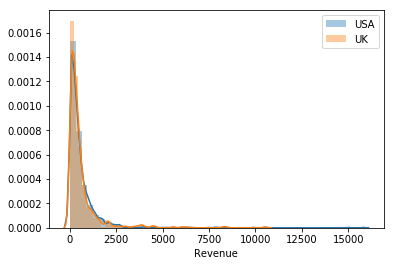

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot(employee_usa['Revenue'], label='USA')
sns.distplot(employee_uk['Revenue'], label='UK')
plt.legend();

## USA vs. UK

In [14]:
# Hypothesis: Do employees working in the USA bring in more money then employees in the UK?
# H0: mu_usa = mu_uk
# Ha: mu_usa != mu_uk (two tail test)
# alpha = 0.05
import scipy.stats as stats
stats.mannwhitneyu(employee_usa['Revenue'],employee_uk['Revenue'])
# Use a mann whitney u test because it is non parameteric
# the p-value is greater than alpha .05, we fail to reject the null

MannwhitneyuResult(statistic=447564.0, pvalue=0.40244938308086037)

In [15]:
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, od.Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               """)
employee_us_uk = pd.DataFrame(cur.fetchall())
employee_us_uk.columns = [x[0] for x in cur.description]
display(employee_us_uk.head(2))
len(employee_us_uk)

,Title,Id,FirstName,City,Region,Country,Revenue
0,Sales Manager,5,Steven,London,British Isles,UK,168.0
1,Sales Manager,5,Steven,London,British Isles,UK,98.0


2155

In [16]:
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, AVG(od.Revenue) as Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               GROUP BY FirstName
               """)
employee_us_uk_1 = pd.DataFrame(cur.fetchall())
employee_us_uk_1.columns = [x[0] for x in cur.description]
display(employee_us_uk_1.head(2))
len(employee_us_uk_1)

,Title,Id,FirstName,City,Region,Country,Revenue
0,"Vice President, Sales",2,Andrew,Tacoma,North America,USA,691.028029
1,Sales Representative,9,Anne,London,British Isles,UK,722.505294


9

In [17]:
cur.execute("""SELECT COUNT(Quantity), CategoryName
               FROM Customer c
               JOIN [Order] o
               ON c.Id = o.CustomerId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Employee e
               ON o.EmployeeId = e.Id
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category cy
               ON p.CategoryId = cy.Id
               GROUP BY CategoryName
               
               """)
customer_order1 = pd.DataFrame(cur.fetchall())
customer_order1.columns = [x[0] for x in cur.description]
display(customer_order1.head(2))
len(customer_order1)

,COUNT(Quantity),CategoryName
0,389,Beverages
1,209,Condiments


8

In [18]:
# individual employees from both USA and UK
# H0: All employees generate the same revenue
# Ha: At least one employee is different
sm.stats.anova_lm(ols('Revenue ~ FirstName', data=employee_us_uk).fit())
# p-value is less than alpha, not by much use the tukey hsd to see if there is a difference

,df,sum_sq,mean_sq,F,PR(>F)
FirstName,8.0,1.472611e+07,1.840763e+06,1.966553,0.046929
Residual,2146.0,2.008732e+09,9.360354e+05,NaN,NaN


In [19]:
tukey_us_uk_emp = pairwise_tukeyhsd(employee_us_uk['Revenue'], employee_us_uk['FirstName'])
tukey_us_uk_emp.summary()

group1,group2,meandiff,lower,upper,reject
Andrew,Anne,31.4773,-317.4909,380.4454,False
Andrew,Janet,-59.2123,-315.2499,196.8252,False
Andrew,Laura,-203.0962,-471.705,65.5126,False
Andrew,Margaret,-136.526,-379.2787,106.2267,False
Andrew,Michael,-251.0689,-552.9911,50.8533,False
Andrew,Nancy,-134.1944,-386.3841,117.9953,False
Andrew,Robert,16.746,-281.1054,314.5975,False
Andrew,Steven,-103.0598,-441.5426,235.423,False
Anne,Janet,-90.6896,-426.0208,244.6417,False
Anne,Laura,-234.5735,-579.5988,110.4519,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


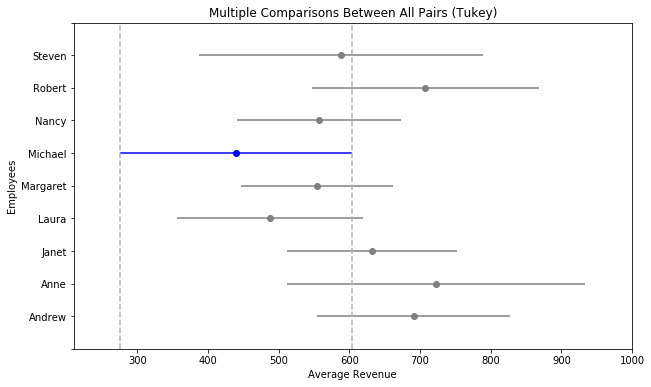

In [20]:
tukey_us_uk_emp.plot_simultaneous(comparison_name='Michael', ylabel='Employees', xlabel='Average Revenue').show()
# shows that there is no signficant differences between the employees in the US vs. UK

In [21]:
# H0: sales rep = sales manager 
# Ha: sales rep != sales manager
sm.stats.anova_lm(ols('Revenue ~ Title*FirstName', data=employee_uk).fit())
# p-value is greater than alpha - fail to reject the null

,df,sum_sq,mean_sq,F,PR(>F)
Title,1.0,5.147107e+04,5.147107e+04,0.051551,0.820468
FirstName,3.0,7.894684e+06,2.631561e+06,2.635649,0.049018
Title:FirstName,3.0,3.238651e+05,1.079550e+05,0.108123,0.955345
Residual,564.0,5.631252e+08,9.984489e+05,NaN,NaN


____

## Looking through the Employee Territory Table

In [22]:
# This coincides with there only being 9 employees
cur.execute("""SELECT *
               FROM EmployeeTerritory""")
emp_territory = pd.DataFrame(cur.fetchall())
emp_territory.columns = [x[0] for x in cur.description]
display(emp_territory.head())
len(emp_territory)

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


49

___

## Looking through the Territory Table

In [28]:
cur.execute("""SELECT *
               FROM Territory""")
territory = pd.DataFrame(cur.fetchall())
territory.columns = [x[0] for x in cur.description]
display(territory.head())
len(territory)

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


53

___

## Looking through the Customer Table

In [23]:
# Where are the customers coming from?
# Only 91 customers
cur.execute("""SELECT *
               FROM Customer
               ORDER BY Country""")
customer = pd.DataFrame(cur.fetchall())
customer.columns = [x[0] for x in cur.description]
display(customer.head(2))
len(customer)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,CACTU,Cactus Comidas para llevar,Patricio Simpson,Sales Agent,Cerrito 333,Buenos Aires,South America,1010,Argentina,(1) 135-5555,(1) 135-4892
1,OCEAN,Océano Atlántico Ltda.,Yvonne Moncada,Sales Agent,Ing. Gustavo Moncada 8585 Piso 20-A,Buenos Aires,South America,1010,Argentina,(1) 135-5333,(1) 135-5535


91

In [24]:
# what are customers ordering?
cur.execute("""SELECT CompanyName, e.Region, e.Country, o.Id, FirstName, ProductId, od.UnitPrice, Quantity, 
               Discount, CategoryName, od.Revenue
               FROM Customer c
               JOIN [Order] o
               ON c.Id = o.CustomerId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Employee e
               ON o.EmployeeId = e.Id
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category cy
               ON p.CategoryId = cy.Id
               
               """)
customer_order = pd.DataFrame(cur.fetchall())
customer_order.columns = [x[0] for x in cur.description]
display(customer_order.head(2))
len(customer_order)
# Employee are the employees from Northwind, the buyers are Company Name

,CompanyName,Region,Country,Id,FirstName,ProductId,UnitPrice,Quantity,Discount,CategoryName,Revenue
0,Vins et alcools Chevalier,British Isles,UK,10248,Steven,11,14.0,12,0.0,Dairy Products,168.0
1,Vins et alcools Chevalier,British Isles,UK,10248,Steven,42,9.8,10,0.0,Grains/Cereals,98.0


2078

## Looking through the Shipper Table

In [25]:
cur.execute("""SELECT *
               FROM Shipper""")
shipper = pd.DataFrame(cur.fetchall())
shipper.columns = [x[0] for x in cur.description]
display(shipper.head())
len(shipper)

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


3

**Note: 'CustomerCustomerDemo' and 'CustomerDemographic' tables showed to be empty.**

____

In [26]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [27]:
cur.execute("""SELECT OrderDate, Quantity, OrderId, SUM(od.Revenue) as Total_Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               GROUP BY OrderId
               """)
a = pd.DataFrame(cur.fetchall())
a.columns = [x[0] for x in cur.description]
display(a.head())
len(a)

,OrderDate,Quantity,OrderId,Total_Revenue
0,2012-07-04,5,10248,440.00
1,2012-07-05,40,10249,1863.40
2,2012-07-08,15,10250,1552.60
3,2012-07-08,20,10251,654.06
4,2012-07-09,40,10252,3597.90


830

In [28]:
a['OrderDate'] = pd.to_datetime(a.OrderDate)
a['day'] = a['OrderDate'].dt.day_name()

In [29]:
# order day vs. quantity?
sm.stats.anova_lm(ols('Quantity ~ day', data=a).fit())

,df,sum_sq,mean_sq,F,PR(>F)
day,4.0,528.755380,132.188845,0.366879,0.832297
Residual,825.0,297252.908476,360.306556,NaN,NaN


___

In [30]:
cur.execute("""SELECT OrderDate, OrderId, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId""")
order1 = pd.DataFrame(cur.fetchall())
order1.columns = [x[0] for x in cur.description]
display(order1.head(2))
len(order1)

,OrderDate,OrderId,Revenue
0,2012-07-04,10248,168.0
1,2012-07-04,10248,98.0


2155

___

Question: Does season have statistically significant effect on types of categories being purchased?

In [ ]:
# Separate by season - Googled it
# Spring runs from March 1 to May 31
# Summer runs from June 1 to August 31
# Fall (autumn) runs from September 1 to November 30
# Winter runs from December 1 to February 28
# Years that are in the database: 2012, 2013, 2014

In [6]:
# For spring 2012 there are no orders placed
# For summer 2014 there are no orders placed
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2012-07-01' AND '2012-09-31'
               ORDER BY OrderDate ASC""")
summer2012 = pd.DataFrame(cur.fetchall())
summer2012.columns = [x[0] for x in cur.description]
display(summer2012.head())
len(summer2012)

,OrderDate,CategoryName,Revenue
0,2012-07-04,Dairy Products,168.0
1,2012-07-04,Grains/Cereals,98.0
2,2012-07-04,Dairy Products,174.0
3,2012-07-05,Produce,167.4
4,2012-07-05,Produce,1696.0


185

In [7]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-07-01' AND '2013-09-31'
               ORDER BY OrderDate ASC""")
summer2013 = pd.DataFrame(cur.fetchall())
summer2013.columns = [x[0] for x in cur.description]
display(summer2013.head())
len(summer2013)

,OrderDate,CategoryName,Revenue
0,2013-07-01,Confections,142.50
1,2013-07-02,Grains/Cereals,23.80
2,2013-07-02,Confections,187.38
3,2013-07-02,Beverages,360.00
4,2013-07-02,Condiments,260.00


256

In [8]:
summer = pd.concat([summer2012, summer2013])

In [9]:
summer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 0 to 255
Data columns (total 3 columns):
OrderDate       441 non-null object
CategoryName    441 non-null object
Revenue         441 non-null float64
dtypes: float64(1), object(2)
memory usage: 13.8+ KB


## Summer

In [10]:
summer = summer.rename(columns={'Revenue': 'Summer_Rev'})
print(summer.info())
display(summer.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 0 to 255
Data columns (total 3 columns):
OrderDate       441 non-null object
CategoryName    441 non-null object
Summer_Rev      441 non-null float64
dtypes: float64(1), object(2)
memory usage: 13.8+ KB
None


,OrderDate,CategoryName,Summer_Rev
0,2012-07-04,Dairy Products,168.0
1,2012-07-04,Grains/Cereals,98.0
2,2012-07-04,Dairy Products,174.0
3,2012-07-05,Produce,167.4
4,2012-07-05,Produce,1696.0


___

In [11]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-03-01' AND '2013-05-31'
               ORDER BY CategoryName""")
spring2013 = pd.DataFrame(cur.fetchall())
spring2013.columns = [x[0] for x in cur.description]
display(spring2013.head())
len(spring2013)

,OrderDate,CategoryName,Revenue
0,2013-03-04,Beverages,110.4
1,2013-03-05,Beverages,90.0
2,2013-03-06,Beverages,100.8
3,2013-03-07,Beverages,552.0
4,2013-03-10,Beverages,516.8


254

In [12]:
cur.execute("""SELECT OrderDate, Categoryname, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2014-03-01' AND '2014-05-31'
               ORDER BY OrderDate ASC""")
spring2014 = pd.DataFrame(cur.fetchall())
spring2014.columns = [x[0] for x in cur.description]
display(spring2014.head())
len(spring2014)

,OrderDate,CategoryName,Revenue
0,2014-03-02,Seafood,25.89
1,2014-03-02,Dairy Products,340.00
2,2014-03-02,Beverages,810.00
3,2014-03-02,Dairy Products,637.50
4,2014-03-02,Confections,418.80


417

In [13]:
spring = pd.concat([spring2013, spring2014])

## Spring

In [14]:
spring = spring.rename(columns={'Revenue': 'Spring_Rev'})
print(spring.info())
display(spring.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 0 to 416
Data columns (total 3 columns):
OrderDate       671 non-null object
CategoryName    671 non-null object
Spring_Rev      671 non-null float64
dtypes: float64(1), object(2)
memory usage: 21.0+ KB
None


,OrderDate,CategoryName,Spring_Rev
0,2013-03-04,Beverages,110.4
1,2013-03-05,Beverages,90.0
2,2013-03-06,Beverages,100.8
3,2013-03-07,Beverages,552.0
4,2013-03-10,Beverages,516.8


___

In [15]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue 
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2012-09-01' AND '2012-11-30'
               ORDER BY OrderDate ASC""")
fall2012 = pd.DataFrame(cur.fetchall())
fall2012.columns = [x[0] for x in cur.description]
display(fall2012.head())
len(fall2012)

,OrderDate,CategoryName,Revenue
0,2012-09-02,Grains/Cereals,121.6
1,2012-09-03,Dairy Products,201.6
2,2012-09-03,Confections,417.0
3,2012-09-03,Dairy Products,432.0
4,2012-09-04,Beverages,864.0


196

In [16]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-09-01' AND '2013-11-30'
               ORDER BY OrderDate ASC""")
fall2013 = pd.DataFrame(cur.fetchall())
fall2013.columns = [x[0] for x in cur.description]
display(fall2013.head())
len(fall2013)

,OrderDate,CategoryName,Revenue
0,2013-09-01,Confections,82.800
1,2013-09-01,Grains/Cereals,315.000
2,2013-09-01,Seafood,38.835
3,2013-09-01,Grains/Cereals,280.000
4,2013-09-02,Confections,471.150


290

In [17]:
fall = pd.concat([fall2012, fall2013])

## Fall

In [18]:
fall = fall.rename(columns={'Revenue': 'Fall_Rev'})
print(fall.info())
display(fall.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 289
Data columns (total 3 columns):
OrderDate       486 non-null object
CategoryName    486 non-null object
Fall_Rev        486 non-null float64
dtypes: float64(1), object(2)
memory usage: 15.2+ KB
None


,OrderDate,CategoryName,Fall_Rev
0,2012-09-02,Grains/Cereals,121.6
1,2012-09-03,Dairy Products,201.6
2,2012-09-03,Confections,417.0
3,2012-09-03,Dairy Products,432.0
4,2012-09-04,Beverages,864.0


In [19]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2012-12-01' AND '2012-12-31'
               ORDER BY OrderDate ASC""")
winter_1_2012 = pd.DataFrame(cur.fetchall())
winter_1_2012.columns = [x[0] for x in cur.description]
display(winter_1_2012.head())
len(winter_1_2012)

,OrderDate,CategoryName,Revenue
0,2012-12-02,Meat/Poultry,1980.0
1,2012-12-02,Grains/Cereals,410.4
2,2012-12-03,Beverages,183.6
3,2012-12-03,Grains/Cereals,798.0
4,2012-12-03,Produce,136.0


81

In [20]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-01-01' AND '2013-02-28'
               ORDER BY OrderDate ASC""")
winter_2_2012 = pd.DataFrame(cur.fetchall())
winter_2_2012.columns = [x[0] for x in cur.description]
display(winter_2_2012.head())
len(winter_2_2012)

,OrderDate,CategoryName,Revenue
0,2013-01-01,Meat/Poultry,2079.0
1,2013-01-01,Beverages,504.0
2,2013-01-01,Confections,480.0
3,2013-01-01,Seafood,372.6
4,2013-01-01,Grains/Cereals,2128.0


164

In [21]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-12-01' AND '2013-12-31'
               ORDER BY OrderDate ASC""")
winter_1_2013 = pd.DataFrame(cur.fetchall())
winter_1_2013.columns = [x[0] for x in cur.description]
display(winter_1_2013.head())
len(winter_1_2013)

,OrderDate,CategoryName,Revenue
0,2013-12-01,Confections,126.0
1,2013-12-01,Confections,1756.0
2,2013-12-01,Beverages,1035.0
3,2013-12-02,Confections,367.5
4,2013-12-02,Beverages,139.5


114

In [22]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2014-01-01' AND '2014-02-28'
               ORDER BY OrderDate ASC""")
winter_2_2013 = pd.DataFrame(cur.fetchall())
winter_2_2013.columns = [x[0] for x in cur.description]
display(winter_2_2013.head())
len(winter_2_2013)

,OrderDate,CategoryName,Revenue
0,2014-01-01,Grains/Cereals,646.0
1,2014-01-01,Beverages,765.0
2,2014-01-01,Grains/Cereals,140.0
3,2014-01-01,Seafood,42.0
4,2014-01-01,Confections,70.0


274

In [23]:
winter = pd.concat([winter_1_2012, winter_2_2012, winter_1_2013, winter_2_2013 ])

## Winter

In [24]:
winter = winter.rename(columns={'Revenue': 'Winter_Rev'})
print(winter.info())
display(winter.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 0 to 273
Data columns (total 3 columns):
OrderDate       633 non-null object
CategoryName    633 non-null object
Winter_Rev      633 non-null float64
dtypes: float64(1), object(2)
memory usage: 19.8+ KB
None


,OrderDate,CategoryName,Winter_Rev
0,2012-12-02,Meat/Poultry,1980.0
1,2012-12-02,Grains/Cereals,410.4
2,2012-12-03,Beverages,183.6
3,2012-12-03,Grains/Cereals,798.0
4,2012-12-03,Produce,136.0


In [28]:
sm.stats.anova_lm(ols('Summer_Rev ~ CategoryName', data=summer).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,7.883355e+06,1.126194e+06,2.737797,0.008636
Residual,433.0,1.781147e+08,4.113503e+05,NaN,NaN


In [29]:
tukey_summer = pairwise_tukeyhsd(summer['Summer_Rev'], summer['CategoryName'])
tukey_summer.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,26.6118,-336.5839,389.8076,False
Beverages,Confections,109.917,-205.3371,425.171,False
Beverages,Dairy Products,204.1181,-107.8461,516.0823,False
Beverages,Grains/Cereals,37.4262,-340.0803,414.9327,False
Beverages,Meat/Poultry,512.0257,112.8434,911.2079,True
Beverages,Produce,232.3942,-229.1513,693.9396,False
Beverages,Seafood,104.9715,-215.0527,424.9957,False
Condiments,Confections,83.3052,-286.9299,453.5402,False
Condiments,Dairy Products,177.5063,-189.9315,544.9441,False
Condiments,Grains/Cereals,10.8143,-413.6854,435.3141,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


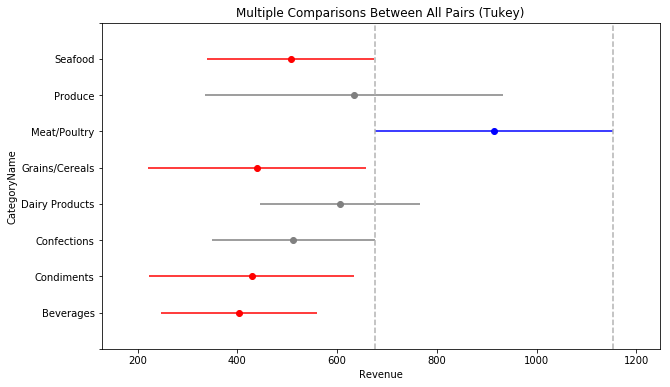

In [31]:
tukey_summer.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

In [32]:
sm.stats.anova_lm(ols('Spring_Rev ~ CategoryName', data=spring).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,1.828522e+07,2.612174e+06,2.592158,0.012113
Residual,663.0,6.681198e+08,1.007722e+06,NaN,NaN


In [33]:
tukey_spring = pairwise_tukeyhsd(spring['Spring_Rev'], spring['CategoryName'])
tukey_spring.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-202.9509,-644.3146,238.4128,False
Beverages,Confections,-59.9398,-471.8783,351.9987,False
Beverages,Dairy Products,-9.8733,-399.2246,379.478,False
Beverages,Grains/Cereals,-193.6672,-686.7294,299.3949,False
Beverages,Meat/Poultry,233.8841,-297.4554,765.2235,False
Beverages,Produce,161.1216,-345.7439,667.9872,False
Beverages,Seafood,-349.487,-746.5406,47.5666,False
Condiments,Confections,143.0111,-329.5716,615.5938,False
Condiments,Dairy Products,193.0776,-259.9517,646.1069,False
Condiments,Grains/Cereals,9.2837,-535.4652,554.0326,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


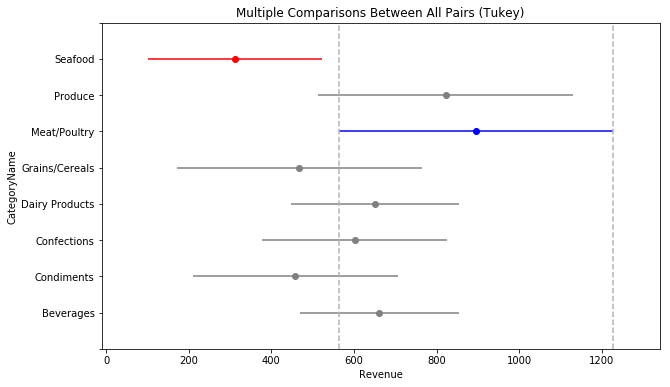

In [34]:
tukey_spring.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

In [35]:
sm.stats.anova_lm(ols('Winter_Rev ~ CategoryName', data=winter).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,2.857973e+07,4.082818e+06,2.859114,0.006068
Residual,625.0,8.925009e+08,1.428001e+06,NaN,NaN


In [36]:
tukey_winter = pairwise_tukeyhsd(winter['Winter_Rev'], winter['CategoryName'])
tukey_winter.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-344.9305,-945.8644,256.0035,False
Beverages,Confections,-448.7328,-927.0692,29.6036,False
Beverages,Dairy Products,-246.8291,-743.5134,249.8553,False
Beverages,Grains/Cereals,-377.5594,-947.6017,192.4828,False
Beverages,Meat/Poultry,161.3873,-418.0777,740.8524,False
Beverages,Produce,-305.1361,-976.3859,366.1137,False
Beverages,Seafood,-488.8957,-995.9087,18.1173,False
Condiments,Confections,-103.8023,-708.8429,501.2383,False
Condiments,Dairy Products,98.1014,-521.5467,717.7495,False
Condiments,Grains/Cereals,-32.629,-712.4941,647.2362,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


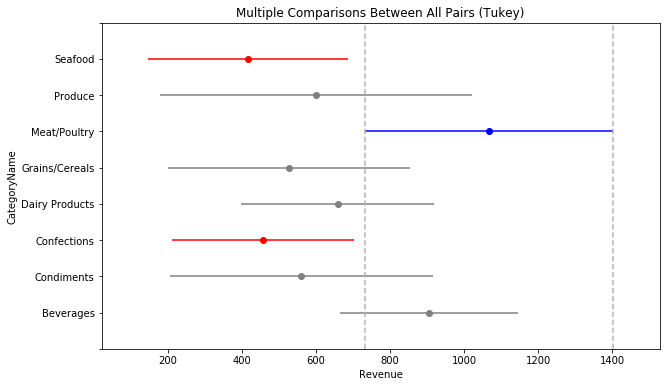

In [37]:
tukey_winter.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

In [38]:
sm.stats.anova_lm(ols('Fall_Rev ~ CategoryName', data=fall).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,1.279856e+07,1.828365e+06,3.22437,0.002376
Residual,478.0,2.710479e+08,5.670457e+05,NaN,NaN


In [39]:
tukey_fall = pairwise_tukeyhsd(fall['Fall_Rev'], fall['CategoryName'])
tukey_fall.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-89.4588,-503.7473,324.8298,False
Beverages,Confections,-194.3048,-560.2328,171.6232,False
Beverages,Dairy Products,27.8024,-328.4744,384.0792,False
Beverages,Grains/Cereals,-178.2699,-603.4464,246.9066,False
Beverages,Meat/Poultry,336.9413,-100.844,774.7266,False
Beverages,Produce,213.2121,-329.9498,756.3739,False
Beverages,Seafood,-196.6495,-559.1517,165.8526,False
Condiments,Confections,-104.846,-520.1627,310.4706,False
Condiments,Dairy Products,117.2612,-289.5776,524.0999,False
Condiments,Grains/Cereals,-88.8111,-557.1696,379.5473,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


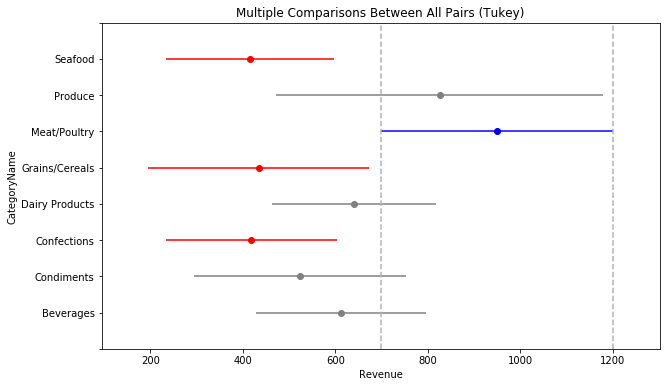

In [40]:
tukey_fall.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

____

### Visualizations for Non-Technical Presentation

- Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
- Do suppliers from some regions generate more revenue than others? Is the revenue different for the different types of categories being supplied? Is the average revenue from a supplier in a certain region different depending on the category that it is supplying?
- Do employees from the USA or UK generate more revenue for Northwind? Do some employees generate more revenue than others? If so, which employees? Does their title effect their sales in any way?
- Do some categories of product sell more during certain seasons? If so, which categories?

## Discount

In [145]:
import matplotlib.pyplot as plt

In [5]:
cur.execute("""SELECT OrderId, Sum(Quantity) as quantity, Discount, AVG(Revenue) as Average_Revenue
            FROM OrderDetail
            GROUP BY OrderId
            """)
df_f = pd.DataFrame(cur.fetchall())
df_f.columns = [x[0] for x in cur.description]
display(df_f.head(2))
len(df_f)

,OrderId,quantity,Discount,Average_Revenue
0,10248,27,0.0,146.666667
1,10249,49,0.0,931.700000


830

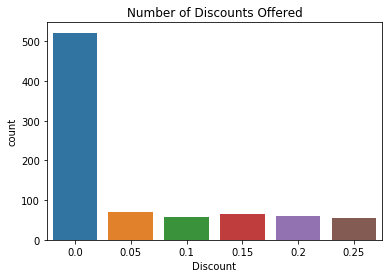

In [147]:
sns.countplot(df_f['Discount'])
plt.title('Number of Discounts Offered');
# Looking at this, it shows that a large majority of the products being sold do not have a discount on them.

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


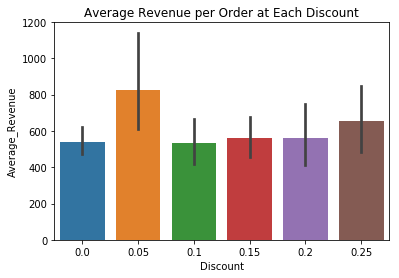

In [148]:
sns.barplot(x='Discount', y='Average_Revenue', data=df_f)
plt.title('Average Revenue per Order at Each Discount')
plt.show();
# This plot shows that having a discount does increase revenue -- which in turn effects the quantity of a product 
# being purchased

In [10]:
cur.execute("""SELECT OrderId, Sum(Quantity) as quantity, AVG(Discount) as Average_Discount
            FROM OrderDetail
            GROUP BY OrderId
            """)
df_g = pd.DataFrame(cur.fetchall())
df_g.columns = [x[0] for x in cur.description]
display(df_g.head(2))
len(df_g)

,OrderId,quantity,Average_Discount
0,10248,27,0.0
1,10249,49,0.0


830

In [11]:
price_per_quantity = df_g.pivot_table(index='quantity', values='Average_Discount', aggfunc=np.mean)
price_per_quantity.head()

,Average_Discount
quantity,
1,0.000000
2,0.030000
3,0.035714
4,0.066667
5,0.027778


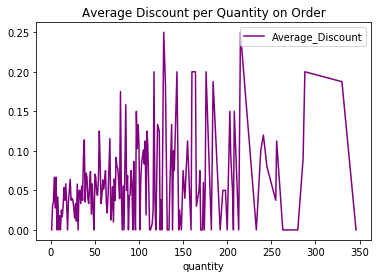

In [13]:
price_per_quantity.plot(kind='line', color='purple', title='Average Discount per Quantity on Order');

## Suppliers

In [151]:
cur.execute("""SELECT CategoryName, Region, Revenue
               FROM Supplier s
               JOIN Product p
               ON s.Id = p.SupplierId
               JOIN Category c
               ON p.CategoryId = c.Id
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               
               """)
supplier_category = pd.DataFrame(cur.fetchall())
supplier_category.columns = [x[0] for x in cur.description]
display(supplier_category.head(2))
len(supplier_category)

,CategoryName,Region,Revenue
0,Dairy Products,Southern Europe,168.0
1,Grains/Cereals,South-East Asia,98.0


2155

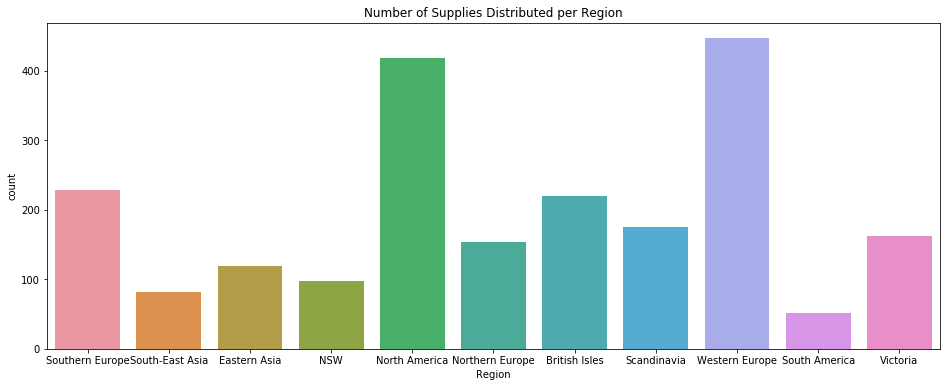

In [152]:
plt.figure(figsize=(16,6))
plt.title('Number of Supplies Distributed per Region')
sns.countplot(x="Region", data=supplier_category);

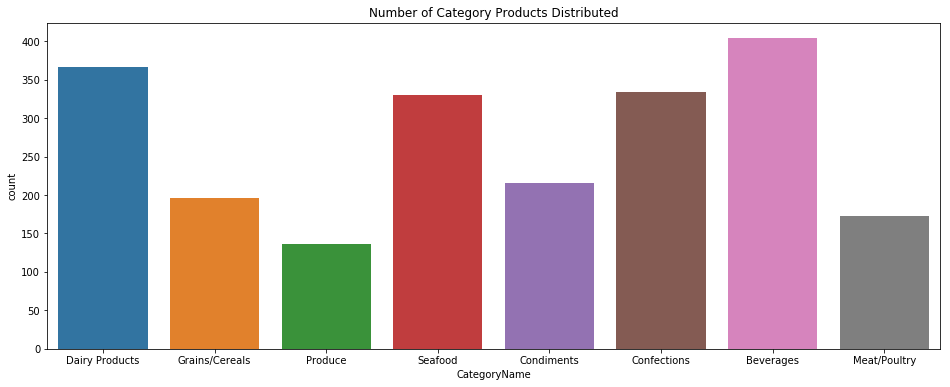

In [153]:
plt.figure(figsize=(16,6))
plt.title('Number of Category Products Distributed')
sns.countplot(x="CategoryName", data=supplier_category);

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


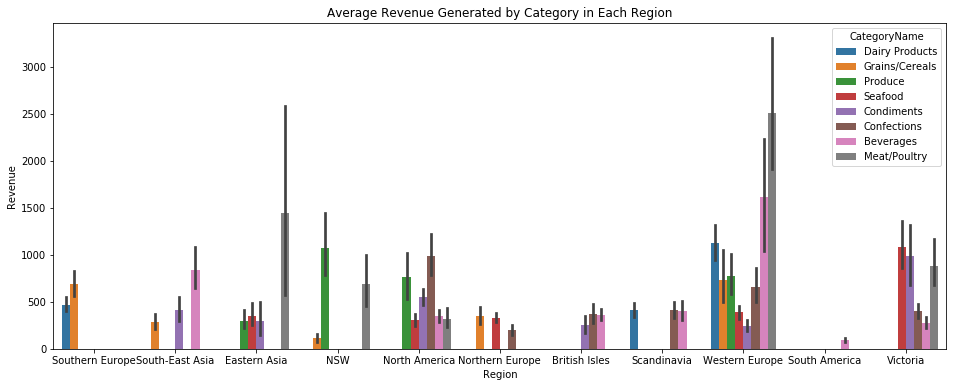

In [154]:
plt.figure(figsize=(16,6))
plt.title('Average Revenue Generated by Category in Each Region')
sns.barplot(x="Region", y='Revenue', hue='CategoryName', data=supplier_category);

## Employees

In [ ]:
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, od.Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               """)
employee_us_uk = pd.DataFrame(cur.fetchall())
employee_us_uk.columns = [x[0] for x in cur.description]
display(employee_us_uk.head(2))
len(employee_us_uk)

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


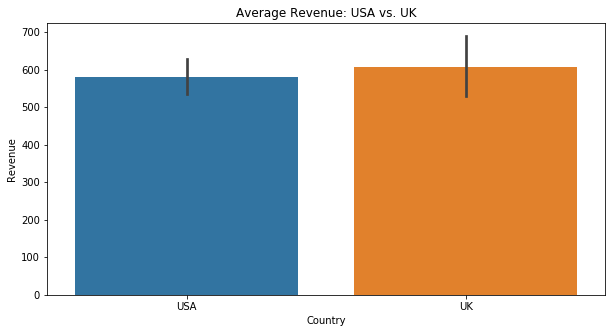

In [156]:
plt.figure(figsize=(10,5))
plt.title('Average Revenue: USA vs. UK')
sns.barplot(x='Country', y="Revenue", data=employee_us_uk, order=['USA', 'UK' ]);

In [157]:
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, AVG(od.Revenue) as Average_Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               GROUP BY OrderId
               """)
employee_us_uk2 = pd.DataFrame(cur.fetchall())
employee_us_uk2.columns = [x[0] for x in cur.description]
display(employee_us_uk2.head(2))
len(employee_us_uk2)

,Title,Id,FirstName,City,Region,Country,Average_Revenue
0,Sales Manager,5,Steven,London,British Isles,UK,146.666667
1,Sales Representative,6,Michael,London,British Isles,UK,931.700000


830

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


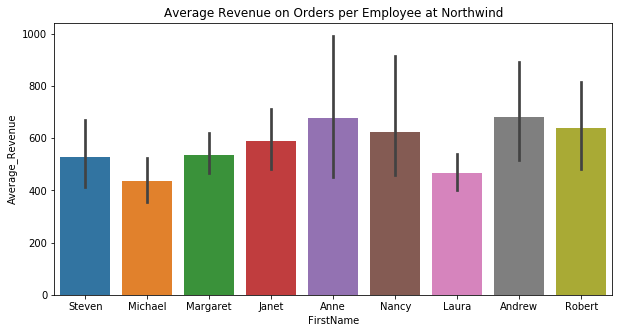

In [266]:
plt.figure(figsize=(10,5))
plt.title('Average Revenue on Orders per Employee at Northwind')
sns.barplot(x="FirstName", y="Average_Revenue", data=employee_us_uk2);

## Seasons

In [175]:
cur.execute("""SELECT OrderDate, CategoryName, SUM(od.Revenue) as Total_Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               GROUP BY CategoryName
               ORDER BY OrderDate ASC""")
category = pd.DataFrame(cur.fetchall())
category.columns = [x[0] for x in cur.description]
display(category)
len(category)

,OrderDate,CategoryName,Total_Revenue
0,2014-05-06,Beverages,267868.1800
1,2014-05-06,Condiments,106047.0850
2,2014-05-06,Confections,167357.2250
3,2014-05-06,Dairy Products,234507.2850
4,2014-05-06,Grains/Cereals,95744.5875
5,2014-05-06,Meat/Poultry,163022.3595
6,2014-05-06,Produce,99984.5800
7,2014-05-06,Seafood,131261.7375


8

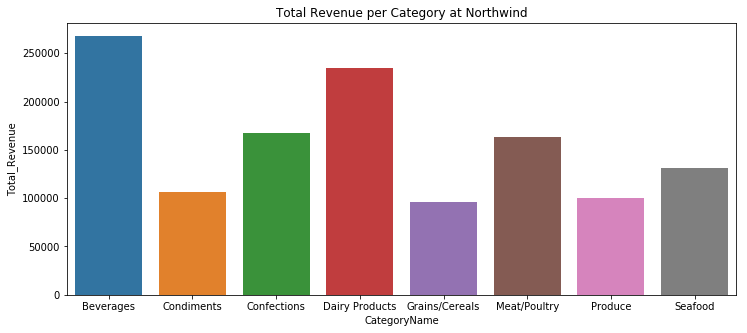

In [176]:
plt.figure(figsize=(12,5))
plt.title('Total Revenue per Category at Northwind')
sns.barplot(x="CategoryName", y="Total_Revenue", data=category);

In [41]:
winter1 = pd.DataFrame(winter.groupby(['CategoryName'])['Winter_Rev'].mean())
display(winter1)

,Winter_Rev
CategoryName,
Beverages,905.957627
Condiments,561.027170
Confections,457.224827
Dairy Products,659.128571
Grains/Cereals,528.398185
Meat/Poultry,1067.344975
Produce,600.821538
Seafood,417.061923


In [42]:
summer1 = pd.DataFrame(summer.groupby(['CategoryName'])['Summer_Rev'].mean())
display(summer1)

,Summer_Rev
CategoryName,
Beverages,402.353457
Condiments,428.965278
Confections,512.270445
Dairy Products,606.471579
Grains/Cereals,439.779625
Meat/Poultry,914.379118
Produce,634.747609
Seafood,507.324928


In [43]:
spring1 = pd.DataFrame(spring.groupby(['CategoryName'])['Spring_Rev'].mean())
display(spring1)

,Spring_Rev
CategoryName,
Beverages,661.468220
Condiments,458.517333
Confections,601.528410
Dairy Products,651.594957
Grains/Cereals,467.801019
Meat/Poultry,895.352273
Produce,822.589850
Seafood,311.981192


In [44]:
fall1 = pd.DataFrame(fall.groupby(['CategoryName'])['Fall_Rev'].mean())
display(fall1)

,Fall_Rev
CategoryName,
Beverages,612.536962
Condiments,523.078200
Confections,418.232199
Dairy Products,640.339368
Grains/Cereals,434.267065
Meat/Poultry,949.478238
Produce,825.749022
Seafood,415.887438


In [45]:
seasons = pd.concat([spring1, summer1, fall1, winter1], axis=1)

In [46]:
seasons

,Spring_Rev,Summer_Rev,Fall_Rev,Winter_Rev
CategoryName,,,,
Beverages,661.468220,402.353457,612.536962,905.957627
Condiments,458.517333,428.965278,523.078200,561.027170
Confections,601.528410,512.270445,418.232199,457.224827
Dairy Products,651.594957,606.471579,640.339368,659.128571
Grains/Cereals,467.801019,439.779625,434.267065,528.398185
Meat/Poultry,895.352273,914.379118,949.478238,1067.344975
Produce,822.589850,634.747609,825.749022,600.821538
Seafood,311.981192,507.324928,415.887438,417.061923


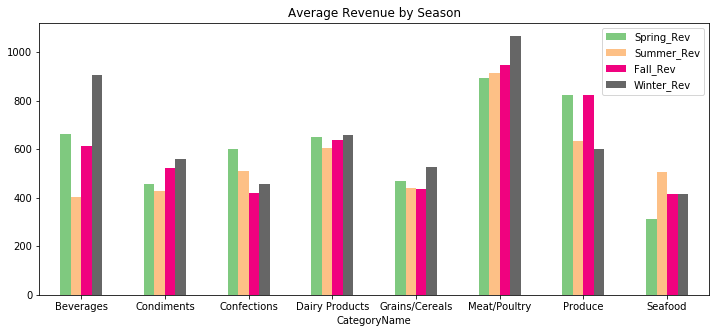

In [53]:
seasons.plot.bar(rot=0, figsize=(12,5), title='Average Revenue by Season', cmap='Accent');
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html